# Bodo Tutorial
Bodo is the simplest and most efficient analytics engine. Bodo accelerates and scales data science programs automatically and enables instant deployment at any scale in all environments, eliminating the need to rewrite Python analytics code to Spark/Scala, SQL or MPI/C++. This tutorial provides a comprehensive overview of Bodo usage. For more details, please visit [docs.bodo.ai](https://docs.bodo.ai).

Let's get started!

# Installation
Bodo is a Python package and can be installed in a Conda environment easily. Install Conda if not available. For example:
```
wget https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh -O miniconda.sh
chmod +x miniconda.sh
./miniconda.sh -b
export PATH=$HOME/miniconda3/bin:$PATH
```
Unpack the Bodo installation package and install Bodo and its dependencies (replace *path-to-bodo-package*):
```
conda create -n Bodo
source activate Bodo
conda install bodo h5py scipy hdf5=*=*mpich* -c file:///path-to-bodo-package/bodo-inc/ -c defaults -c numba -c conda-forge
```
Bodo uses [MPI](https://en.wikipedia.org/wiki/Message_Passing_Interface) for parallelization, which is automatically installed as part of the conda command above. MPI can be configured on clusters easily. The cluster nodes need to have passwordless SSH enabled between them, and there should be a host file listing their addresses (example tutorial [here](https://mpitutorial.com/tutorials/running-an-mpi-cluster-within-a-lan/)).

# Bodo Basics
## JIT Workflow
Bodo provides a just-in-time (JIT) compilation workflow using the *@bodo.jit* decorator. It replaces the decorated Python functions with an optimized and parallelized native binary version using advanced compilation methods.

Bodo uses [Numba](http://numba.pydata.org/) for Python JIT workflow. The decorated function is replaced with a dispatcher object, which is compiled the first time it is called. The function is recompiled only if the argument data types change (not often in practice).

In [1]:
import numpy as np
import pandas as pd
import bodo

@bodo.jit
def f(n):
    return pd.DataFrame({'A': np.random.ranf(n)}).head(3)

print(f)
print(f(10))

CPUDispatcher(<function f at 0x122b56560>)
          A
0  0.076850
1  0.108733
2  0.243824


## Parallel Execution
The decorator compilation optimizes the function and enables its parallelization. However, it does not launch processes or threads on the fly; i.e. no parallelism is introduced in a single Python process. Therefore, launching multiple Python processes with MPI is necessary. For example, we can save the code above in a file and use *mpiexec* to launch 4 processes:

In [2]:
%save -f test_bodo.py 1

The following commands were written to file `test_bodo.py`:
import numpy as np
import pandas as pd
import bodo

@bodo.jit
def f(n):
    return pd.DataFrame({'A': np.random.ranf(n)}).head(3)

print(f)
print(f(10))


In [3]:
!mpiexec -n 4 python test_bodo.py

CPUDispatcher(<function f at 0x10fd9b4d0>)
CPUDispatcher(<function f at 0x1073ab4d0>)
CPUDispatcher(<function f at 0x10a17a4d0>)
CPUDispatcher(<function f at 0x1077c64d0>)
          A
0  0.546557
1  0.652409
2  0.115887
          A
0  0.546557
1  0.652409
2  0.115887
          A
0  0.546557
1  0.652409
2  0.115887
          A
0  0.546557
1  0.652409
2  0.115887


In this example, 4 Python processes are launched and function `f` is parallelized on 4 cores. The same workflow can be used to parallelize programs on a small laptop, all the way to millions of processor cores in the cloud!

### Parallel Execution in Jupyter Notebook
Bodo code can run in parallel inside a notebook using the [ipyparallel](https://ipyparallel.readthedocs.io/en/latest/) package. First, install the necessary packages:
```
conda install jupyter ipyparallel
conda install mpi4py -c conda-forge --no-deps
```
Create an MPI profile for ipython:
```
ipython profile create --parallel --profile=mpi
```
Edit the ~/.ipython/profile_mpi/ipython_config.py file and add the following line:
```
c.IPClusterEngines.engine_launcher_class = 'MPIEngineSetLauncher'
```
Launch the execution engines in another terminal (this can take several seconds):
```
ipcluster start -n 8 –profile=mpi
```

Now run this code in a cell to setup the environment:

In [4]:
import ipyparallel as ipp
c = ipp.Client(profile='mpi')
view = c[:]
view.activate()

After connecting the notebook to the execution engines, cells with the `%%px --block` magic will run on the engines:

In [5]:
%%px --block

import numpy as np
import pandas as pd
import bodo

@bodo.jit
def f(n):
    return pd.DataFrame({'A': np.random.ranf(n)}).head(3)

print(f(10))

[stdout:0] 
          A
0  0.041916
1  0.759617
2  0.744265
[stdout:1] 
          A
0  0.041916
1  0.759617
2  0.744265
[stdout:2] 
          A
0  0.041916
1  0.759617
2  0.744265
[stdout:3] 
          A
0  0.041916
1  0.759617
2  0.744265
[stdout:4] 
          A
0  0.041916
1  0.759617
2  0.744265
[stdout:5] 
          A
0  0.041916
1  0.759617
2  0.744265
[stdout:6] 
          A
0  0.041916
1  0.759617
2  0.744265
[stdout:7] 
          A
0  0.041916
1  0.759617
2  0.744265


### Automatic Distribution
Bodo automatically distributes data and computation of the target function among parallel processes by analyzing it for parallelization. It chooses the best and *safest* possible distribution. For example, returning distributed data is not necessarily *safe*, since the code outside of the bodo scope would need to handle chunks of data instead of the full data. Consider the example below:

In [6]:
%%px --block
import bodo

@bodo.jit
def read_pq():
    df = pd.read_parquet('cycling_dataset.pq')
    return df

df = read_pq()
print(df.shape)

[stdout:0] (3902, 10)
[stdout:1] (3902, 10)
[stdout:2] (3902, 10)
[stdout:3] (3902, 10)
[stdout:4] (3902, 10)
[stdout:5] (3902, 10)
[stdout:6] (3902, 10)
[stdout:7] (3902, 10)


[stderr:0] 
/Users/ehsan/dev/bodo/bodo/transforms/distributed_analysis.py:240: BodoWarning: No parallelism found for function 'read_pq'. This could be due to unsupported usage. See distributed diagnostics for more information.
  "information.".format(self.func_ir.func_id.func_name)


In this example, a dataframe is returned from a jit function to regular Python environment, which prevents parallelism for the whole function. The `BodoWarning` above indicates this lack of parallelism. To get more information about distributions, one can use the `distributed_diagnostics` function which prints diagnostics information about distribution analysis by Bodo:

In [7]:
%%px --block
read_pq.distributed_diagnostics()

[stdout:0] 
Distributed diagnostics for function read_pq, <ipython-input-2-d814eeba1b83> (3)

Data distributions:
   Unnamed: 0.439           REP
   altitude.440             REP
   cadence.441              REP
   distance.442             REP
   hr.443                   REP
   latitude.444             REP
   longitude.445            REP
   power.446                REP
   speed.447                REP
   time.448                 REP
   __index_level_0__.449    REP
   $0.15.465                [<Distribution.REP: 1>, <Distribution.REP: 1>, <Distribution.REP: 1>, <Distribution.REP: 1>, <Distribution.REP: 1>, <Distribution.REP: 1>, <Distribution.REP: 1>, <Distribution.REP: 1>, <Distribution.REP: 1>, <Distribution.REP: 1>]
   $0.23.575                REP
   $df.614                  REP
   $0.6                     REP

Parfor distributions:
No parfors to distribute.

Distributed listing for function read_pq, <ipython-input-2-d814eeba1b83> (3)
--------------------------------------------------| 

In this case, all variables are assigned the `REP` distribution, which means they are replicated and there is no distribution of data. The reason is the return of `df`, which also propagates `REP` to all other variables since they are involved in computation with `df`.

We can change this behavior by a simple annotation for `df`:

In [8]:
%%px --block

@bodo.jit(distributed=['df'])
def read_pq():
    df = pd.read_parquet('cycling_dataset.pq')
    return df

df = read_pq()
print(df.shape)
read_pq.distributed_diagnostics()

[stdout:0] 
(488, 10)
Distributed diagnostics for function read_pq, <ipython-input-4-dda0820ca7f5> (1)

Data distributions:
   Unnamed: 0.812            1D_Block
   altitude.813              1D_Block
   cadence.814               1D_Block
   distance.815              1D_Block
   hr.816                    1D_Block
   latitude.817              1D_Block
   longitude.818             1D_Block
   power.819                 1D_Block
   speed.820                 1D_Block
   time.821                  1D_Block
   __index_level_0__.822     1D_Block
   $0.15.838                 [<Distribution.OneD: 5>, <Distribution.OneD: 5>, <Distribution.OneD: 5>, <Distribution.OneD: 5>, <Distribution.OneD: 5>, <Distribution.OneD: 5>, <Distribution.OneD: 5>, <Distribution.OneD: 5>, <Distribution.OneD: 5>, <Distribution.OneD: 5>]
   $0.23.958                 1D_Block
   $df.1000                  1D_Block
   distributed_return.881    1D_Block
   $dist_return.878.1001     1D_Block

Parfor distributions:
No parfors to

In this case, all variables are assigned the `1D_Block` distribution, which means they are divided in equal chunks among processors. The returned dataframe on each processor is therefore a chunk of the full dataset. This is useful, for example, when computation on chunks is desired outside the scope of Bodo (e.g. mixing Bodo code with custom non-Bodo code and other packages like TensorFlow). In general, the `distributed` flag can be used for both passing distributed chunks as input argument, as well as returning distributed chunks.

### Parallel Print
Bodo limits `print` calls in parallelized jit functions to only one copy (instead of one copy per process) to avoid overwhelming amount of output printing. Furthermore, Bodo does not distribute the input arguments to `print` calls to avoid confusion. One can use `bodo.parallel_print` to change this behavior and even print chunks of data on different processors if necessary:

In [9]:
%%px --block

@bodo.jit(distributed=['df'])
def test_print(n):
    A = np.arange(n)
    B = np.arange(n)
    print("A", A)
    bodo.parallel_print("B", B)

test_print(8)

[stdout:0] 
A [0 1 2 3 4 5 6 7]
B [0]
[stdout:1] B [1]
[stdout:2] B [2]
[stdout:3] B [3]
[stdout:4] B [4]
[stdout:5] B [5]
[stdout:6] B [6]
[stdout:7] B [7]


### Parallel APIs
Bodo provides a small set of parallel APIs to support advanced cases that may need them.

* `bodo.get_rank()` Get the rank of the process (same as MPI_Comm_rank).
* `bodo.get_size()` Get the number of processes (same as MPI_Comm_size).
* `bodo.barrier()` Blocks until all processes have reached this call (same as MPI_Barrier).
* `bodo.gatherv()` Gathers all data chunks into process 0 (same as MPI_Gatherv).
* `bodo.allgatherv()` Gathers all data chunks and delivers to all processes (same as MPI_Allgatherv).

# Parallel I/O
<img style="float: right;" src="img/file-read.jpg">

Efficient parallel data processing requries data I/O to be parallelized effectively as well. Bodo provides parallel file I/O for different formats such as [Parquet](http://parquet.apache.org),
CSV, Numpy binaries and [HDF5](http://www.h5py.org). This diagram demonstrates how chunks of data are partitioned among parallel execution engines by Bodo.

## Parquet
Parquet is a commonly used file format in analytics due to its efficient columnar storage. Bodo supports standard Pandas API for reading Parquet:

In [10]:
%%px --block
from IPython.display import display

@bodo.jit
def pq_read():
    df = pd.read_parquet('cycling_dataset.pq')
    return df.head()

res = pq_read()
if bodo.get_rank() == 0: display(res)  # display results only once

[output:0]

,Unnamed: 0,altitude,cadence,distance,hr,latitude,longitude,power,speed,time
0,0,185.800003,51,3.46,81,30.313309,-97.732711,45,3.459,2016-10-20 22:01:26
1,1,185.800003,68,7.17,82,30.313277,-97.732715,0,3.710,2016-10-20 22:01:27
2,2,186.399994,38,11.04,82,30.313243,-97.732717,42,3.874,2016-10-20 22:01:28
3,3,186.800003,38,15.18,83,30.313212,-97.732720,5,4.135,2016-10-20 22:01:29
4,4,186.600006,38,19.43,83,30.313172,-97.732723,1,4.250,2016-10-20 22:01:30


Bodo parallelizes `pd.read_parquet` and reads equal chunks of dataframe data into the engines. Hence, the returned `df` dataframe is fully distributed and ready for scalable computation.

The file name is a constant value in the example above, which allows Bodo to infer types automatically by looking at the file during compilation time. However, type annotation is required if the file name is not constant:

In [11]:
%%px --block
from IPython.display import display

@bodo.jit(locals={'df':{'altitude': bodo.float64[:],
                  'cadence': bodo.int64[:],
                  'distance': bodo.float64[:],
                  'hr': bodo.int64[:],
                  'latitude': bodo.float64[:],
                  'longitude': bodo.float64[:],
                  'power': bodo.int64[:],
                  'speed': bodo.float64[:],
                  'time': bodo.datetime64ns[:],
                  }})
def pq_read(file_name):
    df = pd.read_parquet(file_name)
    return df.head()

res = pq_read('cycling_dataset.pq')
if bodo.get_rank() == 0: display(res)

[output:0]

,altitude,cadence,distance,hr,latitude,longitude,power,speed,time
0,0.0,185,51.0,3,81.0,30.313309,-97,45.0,1850-10-18 22:23:32.420013003
1,1.0,185,68.0,7,82.0,30.313277,-97,0.0,1850-10-18 22:23:32.420013003
2,2.0,186,38.0,11,82.0,30.313243,-97,42.0,1850-10-18 22:23:32.420013003
3,3.0,186,38.0,15,83.0,30.313212,-97,5.0,1850-10-18 22:23:32.420013003
4,4.0,186,38.0,19,83.0,30.313172,-97,1.0,1850-10-18 22:23:32.420013003


## CSV
CSV files are commonly used since text format can be easier to use. Bodo supports standard Pandas API for reading CSV files:

In [12]:
%%px --block

@bodo.jit
def csv_example():
    df = pd.read_csv('cycling_dataset.csv')
    return df.head()

res = csv_example()
if bodo.get_rank() == 0: display(res)

[output:0]

,0,0.1,185.8000030517578,51,3.4600000381469727,81,30.31330947764218,-97.73271068930626,45,3.4590001106262207,2016-10-20 22:01:26
0,1,1,185.800003,68,7.170000,82,30.313277,-97.732715,0,3.710,2016-10-20 22:01:27
1,2,2,186.399994,38,11.040000,82,30.313243,-97.732717,42,3.874,2016-10-20 22:01:28
2,3,3,186.800003,38,15.180000,83,30.313212,-97.732720,5,4.135,2016-10-20 22:01:29
3,4,4,186.600006,38,19.430000,83,30.313172,-97.732723,1,4.250,2016-10-20 22:01:30
4,5,5,186.600006,0,23.860001,84,30.313130,-97.732724,0,4.435,2016-10-20 22:01:31


If file name is not constant, standard Pandas type annotation can be used to specify types for Bodo:

In [13]:
%%px --block

@bodo.jit
def csv_example(fname):
    coltypes = {'altitude': np.float64,
                'cadence': np.float64,
                'distance': np.float64,
                'hr': np.float64,
                'latitude': np.float64,
                'longitude': np.float64,
                'power': np.float64,
                'speed': np.float64,
                'time': str}
    df = pd.read_csv(fname, names=coltypes.keys(), dtype=coltypes)
    return df.head()

fname = 'cycling_dataset.csv'
res = csv_example(fname)
if bodo.get_rank() == 0: display(res)

[output:0]

,altitude,cadence,distance,hr,latitude,longitude,power,speed,time
0,0.0,0.0,185.800003,51.0,3.46,81.0,30.313309,-97.732711,45
1,1.0,1.0,185.800003,68.0,7.17,82.0,30.313277,-97.732715,0
2,2.0,2.0,186.399994,38.0,11.04,82.0,30.313243,-97.732717,42
3,3.0,3.0,186.800003,38.0,15.18,83.0,30.313212,-97.732720,5
4,4.0,4.0,186.600006,38.0,19.43,83.0,30.313172,-97.732723,1


## HDF5
HDF5 is a common format in scientific computing, especially for multi-dimensional numerical data. HDF5 can be very efficient at scale, since it has native parallel I/O support. Bodo supports the standard h5py APIs:

In [14]:
%%px --block
import h5py

@bodo.jit
def example_h5():
    f = h5py.File("data.h5", "r")
    return f['A'][:].sum()

res = example_h5()
if bodo.get_rank() == 0: display(res)

[output:0]

66

## Numpy Binary Files
Bodo supports reading and writing binary files using Numpy APIs as well.

In [15]:
%%px --block

@bodo.jit
def example_np_io():
    A = np.fromfile("data.dat", np.int64)
    return A.sum()

res = example_np_io()
if bodo.get_rank() == 0: display(res)

[output:0]

45

# Supported APIs

Bodo can automatically parallelize many Python APIs (mostly from Pandas and Numpy)
that are commonly used for data analytics. Please visit [docs.bodo.ai](https://docs.bodo.ai) for a complete list.
Below are some example categories.

<img style="float: right;" src="img/data-parallel.jpg">

## Data-Parallel Operations
Many operations in Numpy and Pandas are fully data-parallel, allowing Bodo to parallelize them across data blocks efficiently without communication between processors.
Many operations such as a large fraction of math operators, filtering, combining columns, normalization, dropping rows/columns, … are in this category.

Example below drops some rows and columns, and creates a new column by extracting month from the time column.

In [16]:
%%px --block

@bodo.jit
def data_par():
    df = pd.read_parquet('cycling_dataset.pq')
    df = df[df.power!=0]
    df['month'] = df.time.dt.month
    df = df.drop(['latitude', 'longitude', 'power', 'time'], axis=1)
    return df.head()

res = data_par()
if bodo.get_rank() == 0: display(res)

[output:0]

,Unnamed: 0,altitude,cadence,distance,hr,speed,month
0,0,185.800003,51,3.460000,81,3.459,10
2,2,186.399994,38,11.040000,82,3.874,10
3,3,186.800003,38,15.180000,83,4.135,10
4,4,186.600006,38,19.430000,83,4.250,10
12,12,186.199997,0,51.610001,80,3.029,10


<img style="float: right;" src="img/reduction.jpg">

## Reduction operations
Some operators such as `sum` require reduction operation across all of data, which implies communication across data blocks. Bodo handles these operations using efficient MPI communication, and makes the output available on all processors.

The example below computes the mean of the 'power' column.

In [17]:
%%px --block

@bodo.jit
def mean_power():
    df = pd.read_parquet('cycling_dataset.pq')
    return df.power.mean()

res = mean_power()
if bodo.get_rank() == 0: display(res)

[output:0]

102.07842132239877

<img style="float: right;" src="img/groupby.jpg">

## GroupBy/Aggregation
Grouping operations, which are typically followed by aggregations/reductions, are
more challenging for parallel and distributed environments. Bodo uses efficient MPI communication primitives to provide fast and scalable groupby/aggregations.

Example below computes the average power output per hour:

In [18]:
%%px --block
import pandas as pd
import numpy as np
import bodo

@bodo.jit
def mean_power_pm():
    df = pd.read_parquet('cycling_dataset.pq')
    df['hour'] = df.time.dt.hour
    grp = df.groupby('hour')
    mean_df = grp['power'].mean()
    return mean_df.head()

res = mean_power_pm()
if bodo.get_rank() == 0: display(res)

[output:0]

22    110.625821
23     71.754079
Name: power, dtype: float64

## Join
Bodo can also efficiently join dataframes, which uses a communication pattern similar to Groupby.

Example below reads data, splits it into two dataframes and re-joins them on time column:

In [19]:
%%px --block

@bodo.jit
def merge_dfs():
    df = pd.read_parquet('cycling_dataset.pq')
    df1 = df[['altitude', 'cadence', 'distance', 'hr', 'time']]
    df2 = df[['latitude', 'longitude', 'power', 'speed', 'time']]
    df3 = df1.merge(df2, on='time')
    return df3.head()

res = merge_dfs()
if bodo.get_rank() == 0: display(res)

[output:0]

,altitude,cadence,distance,hr,time,latitude,longitude,power,speed
0,186.600006,0,23.860001,84,2016-10-20 22:01:31,30.313130,-97.732724,0,4.435
1,186.600006,0,28.350000,84,2016-10-20 22:01:32,30.313093,-97.732723,0,4.490
2,186.600006,0,32.970001,83,2016-10-20 22:01:33,30.313050,-97.732717,0,4.621
3,186.600006,0,37.560001,84,2016-10-20 22:01:34,30.313011,-97.732702,0,4.591
4,186.199997,70,86.339996,88,2016-10-20 22:01:46,30.312580,-97.732621,109,5.553


<img style="float: right;" src="img/rolling.jpg">

## Sliding Windows
Some popular analytics operations, especially for time-series analysis, are based on sliding windows. Examples include moving averages and percentage change. In a distributed setup, these require communication beyond map-reduce (which is the basis of most systems such as Spark). Bodo handles these cases using efficient patterns known from HPC.

Example below computes the moving average of the heart-rate:

In [20]:
%%px --block

@bodo.jit
def mov_avg():
    df = pd.read_parquet('cycling_dataset.pq')
    mv_av = df.hr.rolling(4).mean()
    return mv_av.head()

res = mov_avg()
if bodo.get_rank() == 0: display(res)

[output:0]

0     NaN
1     NaN
2     NaN
3    82.0
4    82.5
Name: hr, dtype: float64

## Explicit Parallel Loops
Sometimes explicit parallel loops are required since a program cannot be written in terms of data-parallel operators easily. In this case, one can use Bodo’s `prange` in place of `range` to specify that a loop can be parallelized. The user is required to make sure the loop does not have cross iteration dependencies except for supported reductions.

The example below demonstrates a parallel loop with a reduction:

In [21]:
%%px --block
import bodo
from bodo import prange
import numpy as np

@bodo.jit
def prange_test(n):
    A = np.random.ranf(n)
    s = 0
    for i in prange(len(A)):
        s += A[i]
    return s

res = prange_test(10)
if bodo.get_rank() == 0: display(res)

[output:0]

4.39991612116377

Currently, reductions using +=, *=, min, and max operators are supported.

## Troubleshooting
Bodo may not be able to compile a function out-of-the-box, usually if there are data types or APIs that Bodo does not support yet. Here are a few recommended steps:
1. Make sure the function works in Python without Bodo
2. Make sure the data types and APIs are supported by Bodo (see documentation for the list of API)
3. Create a minimal reproducer with example data and submit to Bodo support


## Integration with non-Bodo APIs
There are multiple methods for integration with APIs that Bodo does not support natively:
1. Switch to python object mode inside jit functions
2. Pass data in and out of jit functions

### Object mode
Object mode allows switching to a python intepreted context to be able to run non-jittable code. The main requirement is specifying the type of returned values. For example, the following code calls a Scipy function on data elements of a distributed dataset:

In [22]:
%%px --block
import scipy.special as sc

@bodo.jit
def objmode_test(n):
    A = np.random.ranf(n)
    s = 0
    for i in prange(len(A)):
        x = A[i]
        with bodo.objmode(y="float64"):
            y = sc.entr(x)  # call entropy function on each data element
        s += y
    return s

res = objmode_test(10)
if bodo.get_rank() == 0: display(res)

[output:0]

2.875447083413351

See Numba's documentation for [objmode](http://numba.pydata.org/numba-doc/latest/user/withobjmode.html#the-objmode-context-manager) for more details.

### Passing Distributed Data
Bodo can receive or return chunks of distributed data to allow flexible integration with any non-Bodo Python code. The following example passes chunks of data to interpolate with Scipy, and returns interpolation results back to jit function.

In [23]:
%%px --block
import scipy.interpolate

@bodo.jit(distributed={'X', 'Y', 'X2'})
def dist_pass_test(n):
    X = np.arange(n)
    Y = np.exp(-X/3.0)
    X2 = np.arange(0, n, 0.5)
    return X, Y, X2

X, Y, X2 = dist_pass_test(100)
# clip potential out-of-range values
X2 = np.minimum(np.maximum(X2, X[0]), X[-1])
f = scipy.interpolate.interp1d(X, Y)
Y2 = f(X2)

@bodo.jit(distributed={'Y2'})
def dist_pass_res(Y2):
    return Y2.sum()

res = dist_pass_res(Y2)
if bodo.get_rank() == 0: display(res)

[output:0]

6.5527518588343385

The chunk size of input data passed with `distributed` flag cannot change across calls currently. The default chunk size in Bodo for balanced distributed data is ceiling of total number of elements divided by number of processors (*ceil(total_size/np)*), except possibly the last processor which can have fewer elements.

### Visualization
A simple approach for visualization is pulling data to the notebook process from execution engines and using Python visualization libraries. Distributed data can be gathered if there is enough memory on the local machine. Otherwise, a sample of data can be gathered. The example code below demonstrates gathering a portion of data for visualization:

In [24]:
%%px --block

@bodo.jit
def dist_gather_test(n):
    X = np.arange(n)
    Y = np.exp(-X/3.0)
    return bodo.gatherv(Y[::10])  # gather every 10th element


Y_sample = dist_gather_test(100)


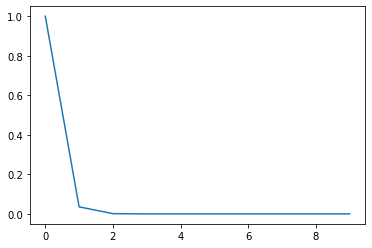

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

Y_sample = view['Y_sample'][0]
plt.plot(Y_sample)